# Open Source GIS Pre-Processing Tutorial

## Table of Contents
1. [Create domain boundary shapefile](#Create-domain-boundary-shapefile)<br>
2. [Build geotiff from geogrid file](#Build-geotiff-from-geogrid-file)<br>
3. [Build routing stack](#Build-routing-stack)<br>
4. [Examine outputs of GIS pre-processor](#Examine-outputs-of-GIS-pre-processor)


## Create domain boundary shapefile

This tool takes an WRF Geogrid file and creates a single polygon shapefile that makes up the boundary of the domain of the M-grid (HGT_M, for example).

#### Get file paths

In [1]:
import os
import Create_Domain_Boundary_Shapefile

cwd = os.getcwd()
data_folder = os.path.join(cwd, 'Croton_Lambert')
in_geogrid = os.path.join(data_folder, 'geo_em.d01.nc')
output_folder = os.path.join(cwd, 'Outputs')

Script initiated at Wed Sep  2 10:58:22 2020


#### Call help for the script on the command line

In [2]:
! python Create_Domain_Boundary_Shapefile.py -h

Script initiated at Wed Sep  2 10:58:27 2020
Script initiated at Wed Sep  2 10:58:27 2020
usage: Create_Domain_Boundary_Shapefile.py [-h] -i IN_NC -o OUT_DIR

This tool takes an WRF Geogrid file and creates a single polygon shapefile
that makes up the boundary of the domain of the M-grid (HGT_M, for example).

optional arguments:
  -h, --help  show this help message and exit
  -i IN_NC    Path to WPS geogrid (geo_em.d0*.nc) file or WRF-Hydro
              Fulldom_hires.nc file.
  -o OUT_DIR  Output directory.


#### Run the script on the command line

In [3]:
! python Create_Domain_Boundary_Shapefile.py -i {in_geogrid} -o {output_folder}

Script initiated at Tue Sep  1 20:54:00 2020
Script initiated at Tue Sep  1 20:54:00 2020
WPS netCDF projection identification initiated...
    Map Projection: Lambert Conformal Conic
    Using MOAD_CEN_LAT for latitude of origin.
    Using Standard Parallel 2 in Lambert Conformal Conic map projection.
    Geo-referencing step completed without error in  0.07 seconds.
    Created projection definition from input NetCDF GEOGRID file.
      ESRI Shapefile driver is available.
  Done producing output vector polygon shapefile in  0.01 seconds
  Output shapefile: C:\Users\casali\Documents\Projects\ForKevin\OpenSource_GIS_ProProcessing\Tutorials\Jupyter\Outputs\geo_em.d01_boundary.shp
Process completed in 0.08 seconds.


#### View the output boundary shapefile

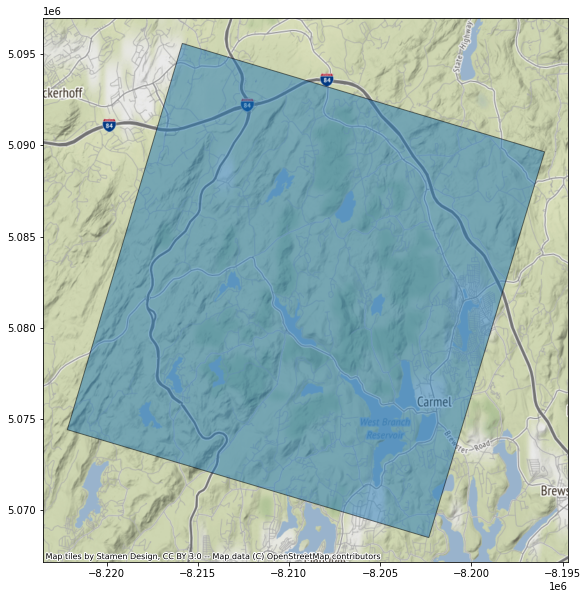

In [4]:
import geopandas
import contextily as ctx

boundary_shp =os.path.join(output_folder,'geo_em.d01_boundary.shp')
df = geopandas.read_file(boundary_shp)
df = df.to_crs(epsg=3857)
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=12)

## Build geotiff from geogrid file

This is a program to export >=2D variables from a WRF-Hydro input file (geogrid or Fulldom_hires) file to an output raster format, with all spatial and coordinate system metadata. If a 3-dimensional variable is selected, individual raster bands will be created in the output raster for each index in the 3rd dimension. If a 4-dimensional variable is selected, the first index in the 4th dimension will be selected and the variable will be treated as a 3-dimensional variable described above.

#### Run the script using Python

In [5]:
import rasterio
from matplotlib import pyplot
from Build_GeoTiff_From_Geogrid_File import build_geogrid_raster

in_geogrid = os.path.join(data_folder, 'geo_em.d01.nc')
output_folder = os.path.join(cwd, 'Outputs')
in_var = "HGT_M"
out_file = os.path.join(output_folder, f'{in_var}.tif')

build_geogrid_raster(in_geogrid, in_var, out_file)

WPS netCDF projection identification initiated...
    Map Projection: Lambert Conformal Conic
    Using MOAD_CEN_LAT for latitude of origin.
    Using Standard Parallel 2 in Lambert Conformal Conic map projection.
    Geo-referencing step completed without error in  0.06 seconds.
    X-dimension: 'west_east'.
    Y-dimension: 'south_north'.
    Reversing order of dimension 'south_north'
    Time dimension found: 'Time'.
      Time dimension size = 1.
    Dimensions and indices or slices on those dimensions:
        Time: 0
        south_north: slice(None, None, -1)
        west_east: slice(None, None, None)
    Size of array being sent to raster: (16, 15)
    GDAL Data type derived from input array: 6 (float32)
    Bands in output raster: 1
    Created GTiff format raster from HGT_M variable: C:\Users\casali\Documents\Projects\ForKevin\OpenSource_GIS_ProProcessing\Tutorials\Jupyter\Outputs\HGT_M.tif


#### View outputs

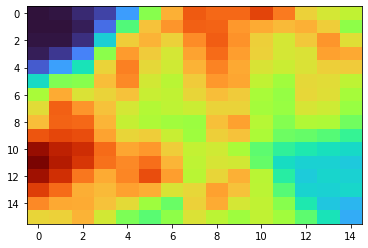

In [6]:
src = rasterio.open(out_file)
pyplot.imshow(src.read(1), cmap='turbo',  aspect='auto')
pyplot.show()

## Build routing stack

This is a program to perform the full routing-stack GIS pre-processing for WRF-Hydro. The inputs will be related to the domain, the desired routing nest factor, and other options and parameter values. The output will be a routing stack zip file with WRF-Hydro domain and parameter files.

• Required:<br>
&emsp;-WRF GEOGRID file (.nc)<br>
&emsp;-High-resolution Elevation<br>
&emsp;&emsp;-Elevation file (Esri GRID, GeoTIFF, etc.)<br>
&emsp;&emsp;-Mosaic Dataset<br>

• Parameters<br>
&emsp;-Regridding Factor – nesting relationship of routing:land grids<br>
&emsp;-Minimum basin size (in routing grid cells)<br>
&emsp;-OVROUGHRTFAC – constant<br>
&emsp;-RETDEPRTFAC – constant<br>
&emsp;-LKSATFAC – constant<br>

• Optional:<br>
&emsp;-Station Locations (.csv)<br>
&emsp;-Lake Polygons (polygon feature class or .shp)<br>

#### Using Python

In [7]:
import shutil
from Build_Routing_Stack import GEOGRID_STANDALONE
from Build_Routing_Stack import varList2D
import wrfhydro_functions as wrfh

cwd = os.getcwd()
data_folder = os.path.join(cwd, 'Croton_Lambert')
output_folder = os.path.join(cwd, 'Outputs')

in_geogrid = os.path.join(data_folder, 'geo_em.d01.nc')
in_dem = os.path.join(data_folder, 'NED_30m_02b_Croton.tif')
out_zip = os.path.join(output_folder, 'croton_test.zip')
projdir = os.path.join(output_folder, 'scratch_dir')
regrid_factor = 10
routing_cells = 200

# Configure logging
logfile = out_zip.replace('.zip', '.log')
tee = wrfh.TeeNoFile(logfile, 'w')

# Create scratch directory for temporary outputs
projdir = os.path.join(output_folder, 'scratchdir')
projdir = os.path.abspath(projdir)
if os.path.exists(projdir):
    shutil.rmtree(projdir)
os.makedirs(projdir)

GEOGRID_STANDALONE(inGeogrid=in_geogrid, regridFactor=regrid_factor, inDEM=in_dem,
                   projdir=projdir, threshold=routing_cells, out_zip=out_zip, varList2D=varList2D )

tee.close()
del tee

  Reach-based routing files will not be created.
WPS netCDF projection identification initiated...
    Map Projection: Lambert Conformal Conic
    Using MOAD_CEN_LAT for latitude of origin.
    Using Standard Parallel 2 in Lambert Conformal Conic map projection.
    Geo-referencing step completed without error in  0.03 seconds.
  Building sub-grid of model grid.
    Original grid spacing dx=1000.0, dy=-1000.0
    Original grid size: rows=16, cols=15
    New grid spacing: dx=100.0, dy=-100.0
    New dimensions: rows=160, cols=150
    Created projection definition from input NetCDF GEOGRID file.
    Proj4: +proj=lcc +lat_0=41.4710083007813 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs
    Coarse grid GeoTransform: 1841998.7848425123 1000.0 0 278496.6013001092 0 -1000.0
    Coarse grid extent [Xmin, Ymin, Xmax, Ymax]: [1841998.7848425123, 262496.6013001092, 1856998.7848425123, 278496.6013001092]
    Fine grid extent [Xmin, Ymin, Xmax, Ymax]:   [1841998.78484251

#### Using command line

On the command line, type 'python' followed by the name of the script and the parameters need by the script. If you are unsure of what parameters are necessary, type '-h' to call the help message.

In [8]:
os.chdir(cwd)
! python Build_Routing_Stack.py -h

Script initiated at Tue Sep  1 20:54:08 2020
usage: Build_Routing_Stack.py [-h] -i INGEOGRID [--CSV INCSV] [-b BASIN_MASK]
                              [-r RB_ROUTING] [-l IN_RESERVOIRS] -d INDEM
                              [-R CELLSIZE] [-t THRESHOLD] [-o OUT_ZIP_FILE]
                              [-O OVROUGHRTFAC_VAL] [-T RETDEPRTFAC_VAL]
                              [--starts CHANNEL_STARTS] [--gw GW_POLYS]

This is a program to perform the full routing-stack GIS pre-processingfor WRF-
Hydro. The inputs will be related to the domain, the desired routing nest
factor, and other options and parameter values. The output will be a routing
stack zip file with WRF-Hydro domain and parameter files.

optional arguments:
  -h, --help            show this help message and exit
  -i INGEOGRID          Path to WPS geogrid (geo_em.d0*.nc) file [REQUIRED]
  --CSV INCSV           Path to input forecast point CSV file [OPTIONAL]
  -b BASIN_MASK         Mask CHANNELGRID variable to forecast basi

### Examine outputs of GIS pre-processor

This tool takes the output zip file from the ProcessGeogrid script and creates a raster from each output NetCDF file. The Input should be a .zip file that was created using the WRF Hydro pre-processing tools. The tool will create the folder which will contain the results (out_folder), if that folder does not already exist.

In [9]:
from Examine_Outputs_of_GIS_Preprocessor import examine_outputs
from wrfhydro_functions import ZipCompat

os.mkdir(os.path.join(output_folder, "Raster_Outputs"))
raster_outputs = os.path.join(output_folder, "Raster_Outputs")

ZipCompat(out_zip).extractall(raster_outputs)
examine_outputs(raster_outputs, skipfiles=[])

  GeoTransform: (1841998.7848425123, 100.0, 0.0, 278496.6013001092, 0.0, -100.0)
  DX: 100.0
  DY: 100.0
  PROJ.4 string: +proj=lcc +lat_0=41.4710083007813 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs
    File Created: C:\Users\casali\Documents\Projects\ForKevin\OpenSource_GIS_ProProcessing\Tutorials\Jupyter\Outputs\Raster_Outputs\CHANNELGRID.tif
    File Created: C:\Users\casali\Documents\Projects\ForKevin\OpenSource_GIS_ProProcessing\Tutorials\Jupyter\Outputs\Raster_Outputs\FLOWDIRECTION.tif
    File Created: C:\Users\casali\Documents\Projects\ForKevin\OpenSource_GIS_ProProcessing\Tutorials\Jupyter\Outputs\Raster_Outputs\FLOWACC.tif
    File Created: C:\Users\casali\Documents\Projects\ForKevin\OpenSource_GIS_ProProcessing\Tutorials\Jupyter\Outputs\Raster_Outputs\TOPOGRAPHY.tif
    File Created: C:\Users\casali\Documents\Projects\ForKevin\OpenSource_GIS_ProProcessing\Tutorials\Jupyter\Outputs\Raster_Outputs\RETDEPRTFAC.tif
    File Created: C:\Users\casali

In [10]:
import ipywidgets as widgets
from ipywidgets import interact

def see_raster(x):
    src = rasterio.open(os.path.join(raster_outputs, f"{x}.tif"))
    if x in ['LATITUDE', 'LONGITUDE']:
        cmap='binary'
    else:
        cmap='turbo'
    pyplot.imshow(src.read(1), cmap=cmap,  aspect='auto')
    pyplot.show()

in_raster = widgets.Dropdown(
    options=[('Basin', 'BASIN'), ('Basin mask', 'basn_msk'), ('Channel grid', 'CHANNELGRID'), ('Flow accumulation', 'FLOWACC'),
            ('Flow direction', 'FLOWDIRECTION'), ('Forecast points', 'frxst_pts'), ('Lake grid', 'LAKEGRID'),
            ('Land use', 'landuse'), ('Latitude', 'LATITUDE'), ('LKSATFAC', 'LKSATFAC'), ('Longitude', 'LONGITUDE'),
            ('OVROUGHRTFAC', 'OVROUGHRTFAC'), ('RETDEPRTFAC', 'RETDEPRTFAC'), ('Stream order', 'STREAMORDER'),
            ('Topography', 'TOPOGRAPHY')],
    value='FLOWACC',
    description='Variable:',
)

interact(see_raster, x=in_raster)

interactive(children=(Dropdown(description='Variable:', index=3, options=(('Basin', 'BASIN'), ('Basin mask', '…

<function __main__.see_raster(x)>